# 匯入套件
進行資料分析之前常要引用的函式庫
如：Pandas Numpy matplotlib...etc等<br>
以及所需分類、分群演算法

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import sklearn
#import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
#from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline 
df = pd.read_excel('order1.xlsx') #資料讀取與其路徑
df

,CustomerID,OrderDate,OrderCode,TotalAmount
0,242174605092,2020/08/28,AB32724840060,2560
1,242281272492,2020/08/07,AB32724210180,2495
2,242281272492,2020/08/07,AB32724210180,1560
3,242281309104,2020/08/14,AB32724420060,2560
4,242281309104,2020/08/14,AB32724420060,1760
...,...,...,...,...
11132,97212000221796,2016/10/03,AB31530090480,2560
11133,97212000221796,2016/10/06,AB31530180180,3840
11134,97212000221796,2016/10/03,AB31530090480,4724
11135,97212000221796,2016/10/06,AB31530180180,3543


In [2]:
# 觀察本次資料集之資料型態及資訊
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11137 entries, 0 to 11136
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CustomerID   11137 non-null  int64 
 1   OrderDate    11137 non-null  object
 2   OrderCode    11137 non-null  object
 3   TotalAmount  11137 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 348.2+ KB


In [3]:
#將資料筆數、四分位數、各式敘述統計資料
df.describe()

,CustomerID,TotalAmount
count,1.113700e+04,11137.000000
mean,1.633964e+13,2804.440334
std,1.849687e+13,2202.130595
min,2.421746e+11,10.000000
25%,1.188240e+13,1530.000000
50%,1.213322e+13,2495.000000
75%,1.237441e+13,3276.000000
max,9.721200e+13,48640.000000


In [4]:
df.head()

,CustomerID,OrderDate,OrderCode,TotalAmount
0,242174605092,2020/08/28,AB32724840060,2560
1,242281272492,2020/08/07,AB32724210180,2495
2,242281272492,2020/08/07,AB32724210180,1560
3,242281309104,2020/08/14,AB32724420060,2560
4,242281309104,2020/08/14,AB32724420060,1760


In [5]:
#從Table中挑選我們要的變數
df = df[['CustomerID','OrderDate','OrderCode','TotalAmount']]

In [6]:
#觀察訂單日期之最大值與最小值
df['OrderDate'].min(), df['OrderDate'].max()

('2016/07/01', '2020/09/30')

In [7]:
#設定統一標準之日期，作為後續變數之資料轉換
PRESENT = dt.datetime(2021,1,1)
#DataFrame列轉換為日期時間
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [8]:
df.head()

,CustomerID,OrderDate,OrderCode,TotalAmount
0,242174605092,2020-08-28,AB32724840060,2560
1,242281272492,2020-08-07,AB32724210180,2495
2,242281272492,2020-08-07,AB32724210180,1560
3,242281309104,2020-08-14,AB32724420060,2560
4,242281309104,2020-08-14,AB32724420060,1760


In [9]:
#使用groupby()方法可以將資料依照自己要的column分組
#將OrderDate OrderCode TotalAmount 分組後再將其個別加總 
RFM= df.groupby('CustomerID').agg({'OrderDate'  : lambda date: (PRESENT - date.max()).days,
                                   'OrderCode'  : lambda num: len(num),
                                   'TotalAmount': lambda price: price.sum()})


In [10]:
RFM

,OrderDate,OrderCode,TotalAmount
CustomerID,,,
242174605092,126,1,2560
242281272492,147,2,4055
242281309104,140,2,4320
242281368612,263,1,1560
242281416072,282,1,1230
...,...,...,...
97212000214044,847,2,10376
97212000214416,1308,1,2760
97212000214860,438,4,13970


In [11]:
RFM.columns

Index(['OrderDate', 'OrderCode', 'TotalAmount'], dtype='object')

In [12]:
#將新的模型(RFM)的Columns重新命名
RFM.columns=['Recency','Frequency','Monetary']
RFM['Recency'] = RFM['Recency'].astype(int)

In [13]:
RFM.head()

,Recency,Frequency,Monetary
CustomerID,,,
242174605092,126,1,2560
242281272492,147,2,4055
242281309104,140,2,4320
242281368612,263,1,1560
242281416072,282,1,1230


# Elbow Method
稱為切割式分群，目的為最小化各群群內變異加總 <br>
【total within-cluster sum of square】簡稱wss。<br>
我們依序計算k = 1 ~ k = n各種分群結果的群內變異加總值<br>
並將之與對應的k值繪製成圖(x軸為k值，y軸為wss)<br>
並找出曲線彎曲（如膝蓋彎曲）處對應的k值<br>
即各群群內變異加總值趨於收斂的轉折點，作為最佳的分群數目。

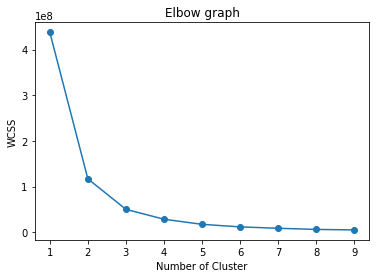

In [14]:
#分群演算法來觀察其模型應該分幾群
from sklearn.cluster import KMeans
wcss = []
Recency = RFM[['Recency']]

for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=0).fit(Recency)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss,marker='o')
plt.title('Elbow graph')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS');

In [15]:
number_of_clusters = 4

In [16]:
#透過quantile函數將三筆指標切分成四個百分位式，
#再將其分別命名為Recency、Frequency、Monetary

quantile_r = RFM["Recency"].quantile(q=[0.25,0.5,0.75])
quantile_f = RFM["Frequency"].quantile(q=[0.25,0.5,0.75])
quantile_m = RFM["Monetary"].quantile(q=[0.25,0.5,0.75])

quantiles = {"Recency" : quantile_r.to_dict() , 
             "Frequency" : quantile_f.to_dict(),
             "Monetary" : quantile_m.to_dict()}


rfmSegmentation = RFM
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
 
def FScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

def MScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [17]:
#將新的資料由條件式劃分後，產生新的欄位R_Quartile、F_Quartile、M_Quartile
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RScore, args=('Recency',quantiles))
rfmSegmentation['F_Quartile'] = rfmSegmentation['Frequency'].apply(FScore, args=('Frequency',quantiles))
rfmSegmentation['M_Quartile'] = rfmSegmentation['Monetary'].apply(MScore, args=('Monetary',quantiles))
RFM.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
242174605092,126,1,2560,4,1,1
242281272492,147,2,4055,4,2,2
242281309104,140,2,4320,4,2,2
242281368612,263,1,1560,3,1,1
242281416072,282,1,1230,3,1,1


In [18]:
RFM['OverallScore'] = RFM['R_Quartile'] + RFM['F_Quartile'] +RFM['M_Quartile'];
RFM.groupby('OverallScore')['Recency','Frequency','Monetary'].mean() #觀察模型統計分佈位置

<ipython-input-18-5279df053ac9>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  RFM.groupby('OverallScore')['Recency','Frequency','Monetary'].mean() #觀察模型統計分佈位置


,Recency,Frequency,Monetary
OverallScore,,,
3,1247.228155,1.000000,1946.388350
4,944.032129,1.112450,2550.261044
5,744.680000,1.400000,3091.156667
6,647.512579,1.814465,4360.330189
7,683.535316,2.546468,6704.237918
8,556.946154,3.376923,8758.569231
9,453.836283,4.323009,11713.889381
10,374.995575,5.761062,17205.433628
11,306.272321,9.022321,26054.375000


In [19]:
RFM['Segment'] = 'Low'
RFM.loc[RFM['OverallScore'] > 6, 'Segment'] = 'Middle'
RFM.loc[RFM['OverallScore'] > 10, 'Segment'] = 'VIP'
RFM.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,OverallScore,Segment
CustomerID,,,,,,,,
242174605092,126,1,2560,4,1,1,6,Low
242281272492,147,2,4055,4,2,2,8,Middle
242281309104,140,2,4320,4,2,2,8,Middle
242281368612,263,1,1560,3,1,1,5,Low
242281416072,282,1,1230,3,1,1,5,Low


# 建立 Machine Learning Model 
在此使用XGBoost Classifier 分類器，在此簡單為XGBoost做一個簡單的介紹，

`Xgboost是Boosting演算法的其中一種，Boosting演算法的思想是將許多弱分類器整合在一起，形成一個強分類器。
因為Xgboost是一種提升樹模型，所以它是將許多樹模型整合在一起，形成一個很強的分類器。                        而所用到的樹模型則是CART迴歸樹模型。
XGBoost簡單說說是一種整合式提升演算法，是將許多基礎模型整合在一起，最終形成一個很強的模型。`

In [20]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 將Low Midde VIP分三群後之變數從類別型態轉為數值型態 0與1

In [21]:
RFM1 = RFM.copy()
RFM1= pd.get_dummies(RFM1)
RFM1.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,OverallScore,Segment_Low,Segment_Middle,Segment_VIP
CustomerID,,,,,,,,,,
242174605092,126,1,2560,4,1,1,6,1,0,0
242281272492,147,2,4055,4,2,2,8,0,1,0
242281309104,140,2,4320,4,2,2,8,0,1,0
242281368612,263,1,1560,3,1,1,5,1,0,0
242281416072,282,1,1230,3,1,1,5,1,0,0


## 定義我們所需要的特徵值與目標

In [22]:
#資料分為訓練組和測試組，測試集用來預測，訓練集用來訓練模型
#X 特徵設定為：Recency、Frequency、Monetary
#Y 標籤設定為：OverallScore
X = RFM1.drop(columns=['OverallScore', 'R_Quartile','F_Quartile','M_Quartile', 'Segment_Low','Segment_Middle',
'Segment_VIP'] ,axis =1)
y = RFM1.OverallScore
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
RFM1

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,OverallScore,Segment_Low,Segment_Middle,Segment_VIP
CustomerID,,,,,,,,,,
242174605092,126,1,2560,4,1,1,6,1,0,0
242281272492,147,2,4055,4,2,2,8,0,1,0
242281309104,140,2,4320,4,2,2,8,0,1,0
242281368612,263,1,1560,3,1,1,5,1,0,0
242281416072,282,1,1230,3,1,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...
97212000214044,847,2,10376,2,2,3,7,0,1,0
97212000214416,1308,1,2760,1,1,1,3,1,0,0
97212000214860,438,4,13970,3,3,3,9,0,1,0


In [24]:
#從訓練組資料中建立XGBOOST模型
xgb_model = XGBClassifier(eval_metric='logloss').fit(X_train, y_train)
#透過XBGOOST算法，可以得出 training set與 test set 準確度
print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)));

C:\Users\9mzx8\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.97


C:\Users\9mzx8\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\9mzx8\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


可以觀察得到，尚未調整前，其準確率非常之高0.97

In [25]:
#取得模型參數
xgb_model.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss'}

# XGBOOST 參數介紹
#-
## XGBOOST作者將參數分成三大類
## 1、通用參數：整體函數控制
## 2、Booster參數：控制每一步的booster(tree/regression)
## 3、學習目標參數：控制訓練目標的表現
參考資料 https://www.itread01.com/articles/1476146171.html

# 調整參數
首先從學習速率(Learning Rate)下手
一開始可以設定高一點，等待其他參數調整後，再將調整回來<br>
在此學習速率設定為0.1。<br>
選擇決策樹的數量<br><br>
eval_metric = logloss<br>
(有效衡量數據的方法) <br><br>
max_depth = 5<br>
(樹的最大深度 )<br><br>
n_estimators = 100<br>
(定義樹的數量) <br><br>
min_child_weight = 1<br>
(決定最小葉子節點樣本權重和) <br><br>
gamma = 0.1 <br>
(葉子節點分裂時，所需要最小損失的減少量，白話文的意思就是<br>
若這個值變大，會葉子節點很難分裂下去，故會使模型趨向保守單一化) <br><br>
subsamplecolsample_bytree<br>
(參數控制對於每棵樹，隨機抽取的比例) = 0.8 <br><br>
而後續還有許多調參數的細節，本次模型先以這部分去做調整<br>
參考資料 https://www.itread01.com/articles/1476146171.html

In [26]:
xgb_model = XGBClassifier(
    eval_metric='logloss',
    max_depth = 5,
    n_estimators = 100,
    min_child_weight = 1,
    gamma = 0.1,
    subsample=0.8,
    colsample_bytree=0.8,).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)));

C:\Users\9mzx8\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.93


C:\Users\9mzx8\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\9mzx8\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


調整參數後其比原先尚未調整前還要合理

In [27]:
y_preds = xgb_model.predict(X_test)

C:\Users\9mzx8\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [28]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           3       0.95      1.00      0.98        40
           4       1.00      0.98      0.99        56
           5       0.91      0.92      0.91        52
           6       0.93      0.85      0.89        66
           7       0.88      0.94      0.91        62
           8       0.81      0.86      0.83        49
           9       0.93      0.84      0.88        44
          10       0.95      1.00      0.97        38
          11       1.00      0.98      0.99        53
          12       1.00      1.00      1.00        46

    accuracy                           0.93       506
   macro avg       0.94      0.94      0.94       506
weighted avg       0.93      0.93      0.93       506



#以Decision Tree 與Random forest做預測
--
先以Entropy做為標準來預測
最大樹深設為6

In [29]:
from sklearn.tree import DecisionTreeClassifier
tree_clf_entropy = DecisionTreeClassifier( criterion='entropy' ,max_depth=6, random_state=42)#(樹深，隨機種子)
tree_clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [30]:
#評估決策樹模型好壞
predictions_entropy = tree_clf_entropy.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions_entropy))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        56
           5       0.94      0.96      0.95        52
           6       0.94      0.95      0.95        66
           7       0.98      0.92      0.95        62
           8       0.90      0.94      0.92        49
           9       0.95      0.95      0.95        44
          10       1.00      1.00      1.00        38
          11       1.00      1.00      1.00        53
          12       1.00      1.00      1.00        46

    accuracy                           0.97       506
   macro avg       0.97      0.97      0.97       506
weighted avg       0.97      0.97      0.97       506



可以看到得分為7,8的精確度只有90%，預測原因為7、8分為中間值，而我們是要準確預測為"3~12分"，因原始分數評估之7、8分差距不大，故精確度會下降。

In [31]:
tree_clf_gini = DecisionTreeClassifier( criterion='gini' ,max_depth=6, random_state=42)#(樹深，隨機種子)
tree_clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [32]:
predictions_gini = tree_clf_gini.predict(X_test)
print(classification_report(y_test,predictions_gini))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        56
           5       0.89      0.96      0.93        52
           6       0.97      0.89      0.93        66
           7       0.89      0.92      0.90        62
           8       0.76      0.80      0.78        49
           9       0.88      0.84      0.86        44
          10       0.97      0.97      0.97        38
          11       1.00      0.98      0.99        53
          12       1.00      1.00      1.00        46

    accuracy                           0.93       506
   macro avg       0.94      0.94      0.94       506
weighted avg       0.94      0.93      0.94       506



再以gini值做為分類標準，發現與上述用entropy值分類有相同情況，一樣再大約8~9分會有精確度不明顯問題。

In [33]:
#使用隨機森林與決策樹做比較
from sklearn.ensemble import RandomForestClassifier

#n_estimator代表要使用多少CART樹（CART樹為使用GINI算法的決策樹）
rfc = RandomForestClassifier(n_estimators=100)

#從訓練組資料中建立隨機森林模型
rfc.fit(X_train,y_train)

#預測測試是否Danger
rfc_pred = rfc.predict(X_test)

In [34]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        56
           5       0.93      0.96      0.94        52
           6       0.97      0.94      0.95        66
           7       1.00      0.94      0.97        62
           8       0.85      0.94      0.89        49
           9       0.93      0.89      0.91        44
          10       0.97      1.00      0.99        38
          11       1.00      1.00      1.00        53
          12       1.00      1.00      1.00        46

    accuracy                           0.96       506
   macro avg       0.96      0.97      0.97       506
weighted avg       0.97      0.96      0.96       506



In [35]:
models = []
#models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("XGBClassifier", DecisionTreeClassifier()))

交叉驗證
---
KFold()  #將數據集拆分為 k 個連續的fold。 然後將每個fold用作一次驗證，而剩餘的 k - 1 個fold形成Train set。

Shuffle 與 Random_State 差別：Suffle類似洗牌，發完牌之後就不會選取。而Random可能會重複選取。


我們並透過交叉驗證函式cross_val_score來分別返回共K個Fold的驗證集accuracy分數。我們發現拆分為九組時，其精確度接與上列預測精確度相去不遠。
故以此結果來解釋，並無overfitting 問題。

In [36]:
for name, model in models: #model唯一可供搜尋之序列，目前為RandomForest與DecisionTree
    kfold = KFold(n_splits=9, random_state=42,shuffle=True) #將數據集拆分為 k 個連續的fold。 然後將每個fold用作一次驗證，而剩餘的 k - 1 個fold形成Train set。
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy") #透過交叉驗證評量分數
    print(name, cv_result)
    print();

RandomForestClassifier [0.98666667 0.96444444 0.98222222 0.98222222 0.96888889 0.97333333
 0.98222222 0.97321429 0.98660714]

DecisionTreeClassifier [0.97777778 0.97777778 0.98666667 0.98666667 0.97777778 0.98222222
 0.98222222 0.98214286 0.99107143]

XGBClassifier [0.97777778 0.97777778 0.98666667 0.98666667 0.97777778 0.98222222
 0.97777778 0.98214286 0.99107143]



Alternative Method
--
試試看改變原本的Y的答案部分，改為預測結果"Low","Middle","VIP"。

其中

Low=1

Middle=2

Vip=3

In [37]:
RFM.keys()

Index(['Recency', 'Frequency', 'Monetary', 'R_Quartile', 'F_Quartile',
       'M_Quartile', 'OverallScore', 'Segment'],
      dtype='object')

In [38]:
RFM['level'] = RFM['Segment']
RFM.loc[RFM['Segment'] == 'Low','level']=int(1)
RFM.loc[RFM['Segment'] == 'Middle','level']=int(2)
RFM.loc[RFM['Segment'] == 'VIP','level']=int(3)
RFM['level'] = RFM['level'].astype(int)

In [39]:
RFM

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,OverallScore,Segment,level
CustomerID,,,,,,,,,
242174605092,126,1,2560,4,1,1,6,Low,1
242281272492,147,2,4055,4,2,2,8,Middle,2
242281309104,140,2,4320,4,2,2,8,Middle,2
242281368612,263,1,1560,3,1,1,5,Low,1
242281416072,282,1,1230,3,1,1,5,Low,1
...,...,...,...,...,...,...,...,...,...
97212000214044,847,2,10376,2,2,3,7,Middle,2
97212000214416,1308,1,2760,1,1,1,3,Low,1
97212000214860,438,4,13970,3,3,3,9,Middle,2


In [40]:
RFM2 = RFM.copy()
X = RFM2.drop(columns=['OverallScore', 'R_Quartile','F_Quartile','M_Quartile', 'Segment','level'] ,axis =1)
y = RFM2.level.to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

接下來使用更動後的解答來做測試。

In [41]:
from sklearn.tree import DecisionTreeClassifier
tree_clf_entropy = DecisionTreeClassifier( criterion='entropy' ,max_depth=6, random_state=42)#(樹深，隨機種子)
tree_clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [42]:
predictions_entropy = tree_clf_entropy.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions_entropy))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       310
           2       1.00      1.00      1.00       295
           3       1.00      1.00      1.00       154

    accuracy                           1.00       759
   macro avg       1.00      1.00      1.00       759
weighted avg       1.00      1.00      1.00       759



拆分之後竟然判斷率為100%...。合理懷疑有overfitting。

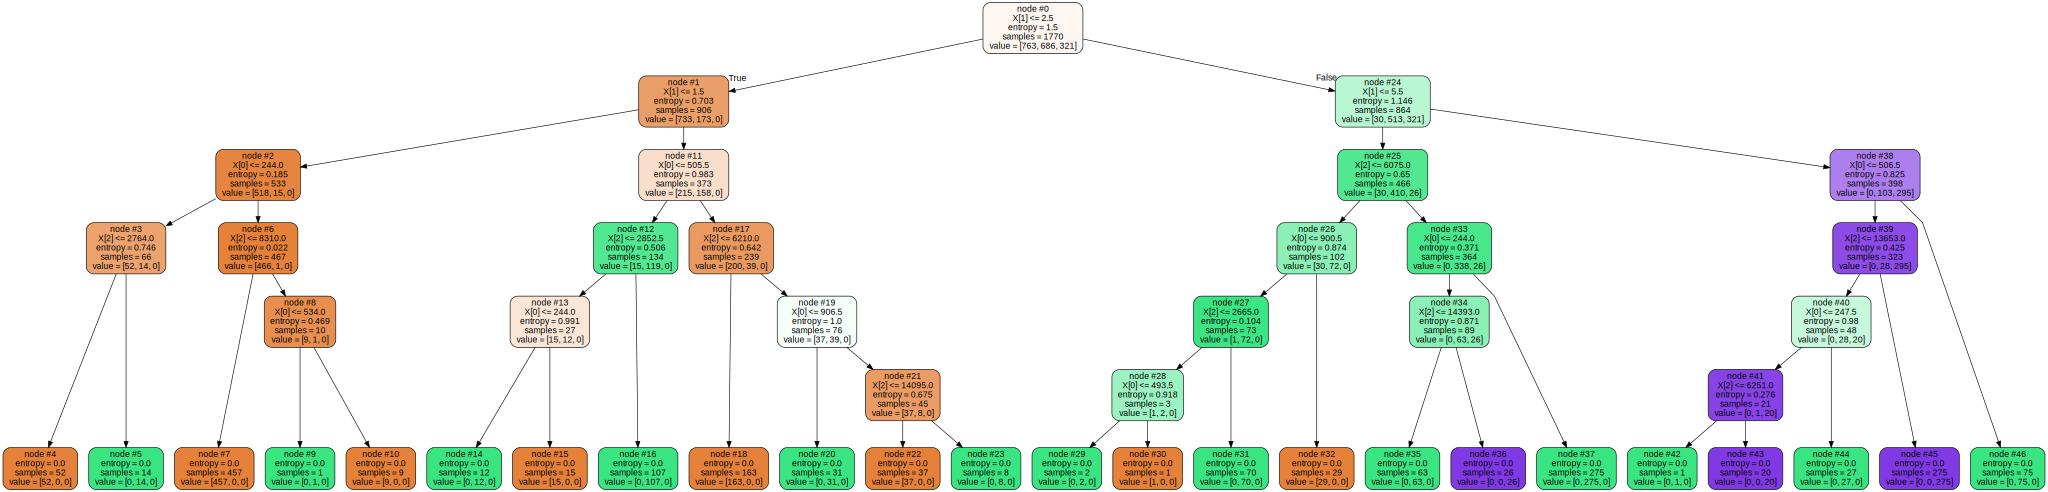

In [44]:
from graphviz import Source    #如果出現error：'No module named 'graphviz'，使用"conda install python-graphviz"
from sklearn.tree import export_graphviz
tree_pic = export_graphviz(
        tree_clf_entropy,
        out_file=None,    #設為none會回傳一個字串
        rounded=True,      #圓邊，boolean
        filled=True,       #填滿顏色(根據純度)，boolean
        node_ids=True,      #顯示節點號碼，boolean
        precision= 3,
        leaves_parallel=True #顯示所有葉節點，boolean     
    )

#Source.from_file(os.path.join(IMAGES_PATH, "tree.dot"))
Source(tree_pic) #語法： Source(export_graphviz())

也由上圖可知，當深度為6時，其leaf node分布非常不平均，雖然最後leaf node 之純度很高，但可以看到有leaf node中的案例數甚至只有兩例，故合理懷疑為overfitting。

In [45]:
from sklearn.tree import DecisionTreeClassifier
tree_clf_entropy = DecisionTreeClassifier( criterion='entropy' ,max_depth=3, random_state=42)#(樹深，隨機種子)
tree_clf_entropy.fit(X_train, y_train)
predictions_entropy = tree_clf_entropy.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions_entropy))

              precision    recall  f1-score   support

           1       0.91      0.93      0.92       310
           2       0.86      0.86      0.86       295
           3       0.91      0.88      0.89       154

    accuracy                           0.89       759
   macro avg       0.89      0.89      0.89       759
weighted avg       0.89      0.89      0.89       759



發現之前強制 depth=6似乎有造成overfitting的現象。此次將depth改為3，獲得的結果較為合理。

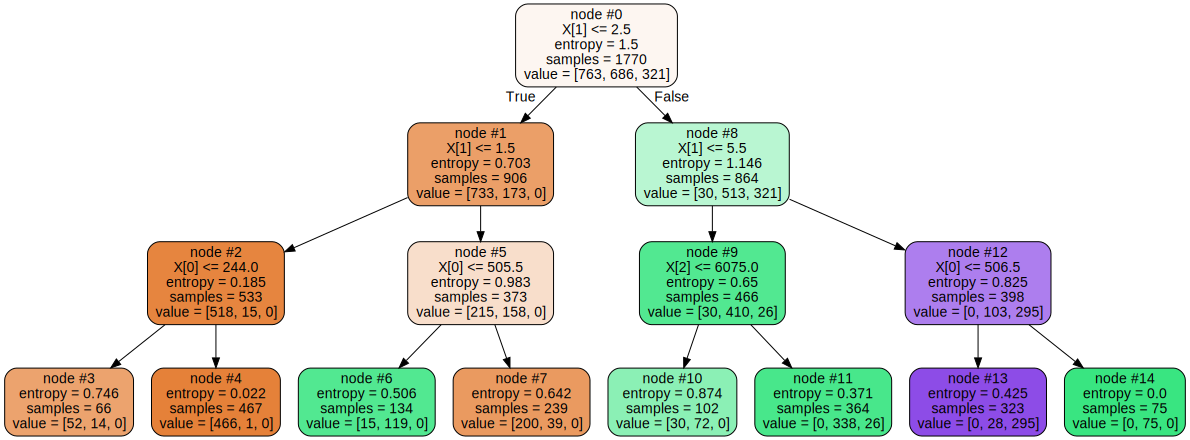

In [47]:
tree_pic = export_graphviz(
        tree_clf_entropy,
        out_file=None,    #設為none會回傳一個字串
        rounded=True,      #圓邊，boolean
        filled=True,       #填滿顏色(根據純度)，boolean
        node_ids=True,      #顯示節點號碼，boolean
        precision= 3,
        leaves_parallel=True #顯示所有葉節點，boolean     
    )

#Source.from_file(os.path.join(IMAGES_PATH, "tree.dot"))
Source(tree_pic) #語法： Source(export_graphviz())

由上圖也可看出，深度為三的樹看起來較為合理，樹也長得較平均。

In [48]:
tree_clf_gini = DecisionTreeClassifier( criterion='gini' ,max_depth=3, random_state=42)#(樹深，隨機種子)
tree_clf_gini.fit(X_train, y_train)
predictions_gini = tree_clf_gini.predict(X_test)
print(classification_report(y_test,predictions_gini))

              precision    recall  f1-score   support

           1       0.91      0.93      0.92       310
           2       0.86      0.86      0.86       295
           3       0.91      0.88      0.89       154

    accuracy                           0.89       759
   macro avg       0.89      0.89      0.89       759
weighted avg       0.89      0.89      0.89       759



可看見上樹再以gini值做為區分，並也將depth改為3，精確度也回到合理區間。#約0.9

最後以隨機森林模型進行訓練，因為一開始資料合理懷疑over fitting，這邊使用隨機森林，因為其有實現簡單、精準度高、抗過
擬合能力強的特性：以下以criterion，n_estimator兩個超參數來做微調。

max_features=None:使用所有參數。

min_samples_leaf = 為759/14約54。 為何如此假設？ 因假設預設的分群正確，又depth正確的情況下，其葉節點分布應該較平均，故假設其結果會為一完滿二元樹共14個節點。分類至其中的案例數目若少於54則不採用此節點。

oob_score = False：這邊我們不使用袋外數據，因為我們覺得樣本數量不夠大，沒有數據落在袋外。不須使用袋外數據來做為test set。

n_estimator=分別以100, 50, 10來討論。

以下為gini值與entropy在最大迭代次數為100的情況。

In [49]:
#n_estimator代表要使用多少CART樹（CART樹為使用GINI算法的決策樹）
rfc = RandomForestClassifier(max_depth = 3, max_features=None, min_samples_leaf = 54,  n_estimators = 100, criterion= 'gini', random_state=42)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred, digits= 4))
rfc = RandomForestClassifier(max_depth = 3, max_features=None, min_samples_leaf = 54,  n_estimators = 100, criterion= 'entropy',  random_state=42)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred, digits= 4))

<ipython-input-49-a90d90a2388b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
<ipython-input-49-a90d90a2388b>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


              precision    recall  f1-score   support

           1     0.9082    0.9258    0.9169       310
           2     0.8467    0.8610    0.8538       295
           3     0.9161    0.8506    0.8822       154

    accuracy                         0.8854       759
   macro avg     0.8903    0.8792    0.8843       759
weighted avg     0.8859    0.8854    0.8853       759

              precision    recall  f1-score   support

           1     0.9082    0.9258    0.9169       310
           2     0.8467    0.8610    0.8538       295
           3     0.9161    0.8506    0.8822       154

    accuracy                         0.8854       759
   macro avg     0.8903    0.8792    0.8843       759
weighted avg     0.8859    0.8854    0.8853       759



以下為gini值與entropy在最大迭代次數為50的情況。

In [50]:
#n_estimator代表要使用多少CART樹（CART樹為使用GINI算法的決策樹）
rfc = RandomForestClassifier(oob_score= True, max_depth = 3, max_features=None, min_samples_leaf = 54,  n_estimators = 50, criterion= 'gini', random_state=42)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred, digits= 4))
rfc = RandomForestClassifier(max_depth = 3, max_features=None, min_samples_leaf = 54,  n_estimators = 50, criterion= 'entropy',  random_state=42)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred, digits= 4))

<ipython-input-50-1d5a670b7a79>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
<ipython-input-50-1d5a670b7a79>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


              precision    recall  f1-score   support

           1     0.9082    0.9258    0.9169       310
           2     0.8492    0.8780    0.8633       295
           3     0.9493    0.8506    0.8973       154

    accuracy                         0.8920       759
   macro avg     0.9022    0.8848    0.8925       759
weighted avg     0.8936    0.8920    0.8921       759

              precision    recall  f1-score   support

           1     0.9082    0.9258    0.9169       310
           2     0.8467    0.8610    0.8538       295
           3     0.9161    0.8506    0.8822       154

    accuracy                         0.8854       759
   macro avg     0.8903    0.8792    0.8843       759
weighted avg     0.8859    0.8854    0.8853       759



以下為gini值與entropy在最大迭代次數為10的情況。

In [51]:
#n_estimator代表要使用多少CART樹（CART樹為使用GINI算法的決策樹）
rfc = RandomForestClassifier(max_depth = 3, max_features=None, min_samples_leaf = 54,  n_estimators = 10, criterion= 'gini', random_state=42)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred, digits= 4))
rfc = RandomForestClassifier(max_depth = 3, max_features=None, min_samples_leaf = 54,  n_estimators = 10, criterion= 'entropy',  random_state=42)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred, digits= 4))

              precision    recall  f1-score   support

           1     0.9082    0.9258    0.9169       310
           2     0.8421    0.8678    0.8548       295
           3     0.9281    0.8377    0.8805       154

    accuracy                         0.8854       759
   macro avg     0.8928    0.8771    0.8841       759
weighted avg     0.8866    0.8854    0.8854       759

              precision    recall  f1-score   support

           1     0.9082    0.9258    0.9169       310
           2     0.8467    0.8610    0.8538       295
           3     0.9161    0.8506    0.8822       154

    accuracy                         0.8854       759
   macro avg     0.8903    0.8792    0.8843       759
weighted avg     0.8859    0.8854    0.8853       759



<ipython-input-51-01157dbff23f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)
<ipython-input-51-01157dbff23f>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


由上述實驗中可得知，當：

 n_estimators = 100時
 
 entropy： 0.9236    gini:0.9196
 
 n_estimators = 50時
 
 entropy： 0.9236    gini:0.9209  
 
 n_estimators = 10時
 
 entropy： 0.9315    gini:0.9144   
而
 整體來看，差異性不大，與前面所做之Decision Tree結果亦相去不遠，但n_estimators = 10時，結果似乎為欠擬。而50~100間的entropy的accuracy完全不變，考慮到數據集內容不夠大，最後採取 n_estimators = 50時，entropy值的精確度：0.9236為最終結果。